In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create instance of taxi environment
env = gym.make('Taxi-v3',render_mode="ansi")

print("Total number of states:", env.observation_space.n)
print("Total number of actions:", env.action_space.n)

Total number of states: 500
Total number of actions: 6


In [4]:
print("Initialized state and mask of allowed actions:")
state, info = env.reset() # reset environment to random state
print(state, info['action_mask'])
print(env.render()) # graphical representation

print("\nRandomly generated (allowed), new state and reward:")
action = env.action_space.sample(info['action_mask'])
state, reward, is_done, _, info = env.step(action=action) # agent interacts with environment
print(action, state, reward)
print(env.render()) # graphical representation

Initialized state and mask of allowed actions:
21 [1 0 0 1 0 0]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Randomly generated (allowed), new state and reward:
0 121 -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



In [141]:
def select_action(state, Q, action_mask, epsilon=0.0):

    # Extract indices of allowed actions
    valid_actions = np.where(action_mask == 1)[0]

    if np.random.rand() < epsilon:
        # Exploration: randomly choose among valid actions
        action_ = np.random.choice(valid_actions)
    else:
        # Exploitation: choose the best action among valid actions
        q_values_valid = Q[state][valid_actions]
        max_q = np.max(q_values_valid)
        
        # In case multiple actions have the same max Q-value, randomly choose among them
        best_actions = valid_actions[q_values_valid == max_q]
        action_ = np.random.choice(best_actions)

    return action_

# Sarsa

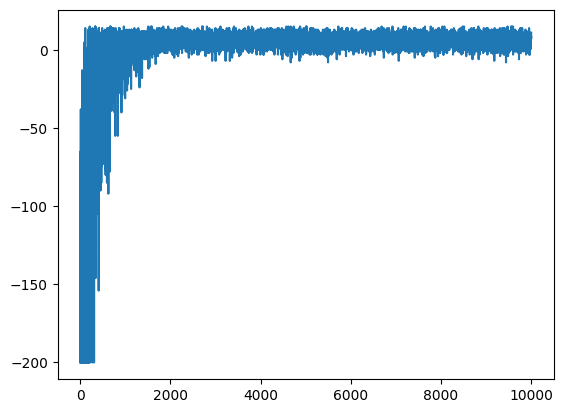

In [142]:
alpha = 0.1
gamma = 0.99
num_episodes = 10000
epsilon = 0.1

Q = np.zeros((env.observation_space.n, env.action_space.n))

sarsa_sum_of_rewards_per_episode = []

for episode in range(num_episodes):

    rewards = []

    # random state and i['action_mask] contains the actions that can be taken
    s, i = env.reset()

    a = select_action(s, Q, i['action_mask'], epsilon)

    while True:

        s_prime, r, is_done, is_terminated, i_prime = env.step(a)

        a_prime = select_action(s_prime, Q, i_prime['action_mask'], epsilon)

        Q[s, a] += alpha * (r + gamma * Q[s_prime, a_prime] - Q[s, a])

        s = s_prime
        a = a_prime
        rewards.append(r)

        if is_done or is_terminated:
            break
    
    sarsa_sum_of_rewards_per_episode.append(np.sum(rewards))

# Plotting results
plt.plot(range(num_episodes), sarsa_sum_of_rewards_per_episode)

probs_final = np.zeros_like(Q)
for state in range(env.observation_space.n):
    action_mask = np.ones(env.action_space.n, dtype=int)
    action_greedy = select_action(state, Q, action_mask, epsilon=0.0)
    probs_final[state, action_greedy] = 1.0

In [111]:
rewards = []
for _ in range(10000):

    state, info = env.reset()
    env.render()
    total_reward = 0
    done = False

    while not done:
        action_mask = info.get('action_mask')
        action = select_action(state, Q, action_mask, epsilon=0)  # Use greedy policy for evaluation
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward
    
    rewards.append(total_reward)

print(np.mean(rewards))

7.5642


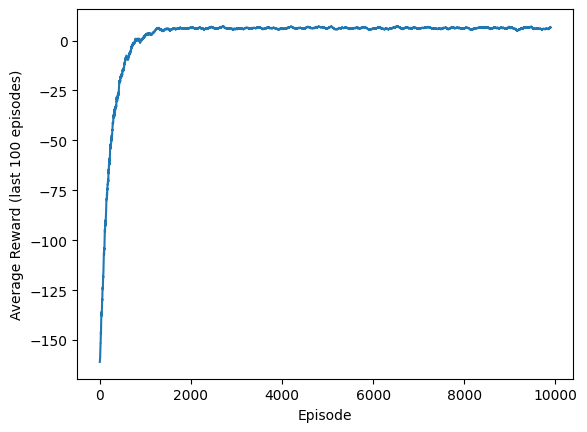

In [ ]:
rolling_avg_rewards = np.convolve(sarsa_sum_of_rewards_per_episode, np.ones(100)/100, mode='valid')
plt.plot(rolling_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward (last 100 episodes)')
plt.show()


# Q-learning

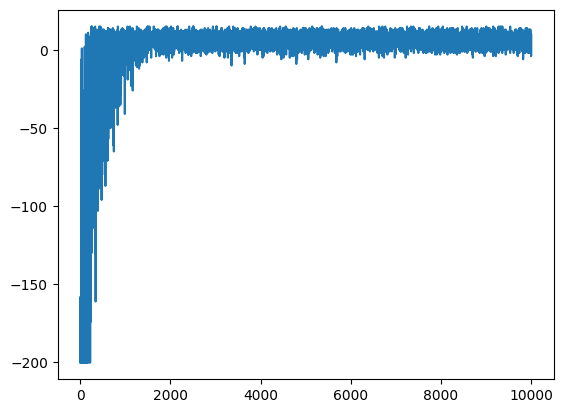

In [143]:
alpha = 0.1
gamma = 0.99
epsilon = 0.1
num_episodes = 10000

Q = np.zeros((env.observation_space.n, env.action_space.n))

q_sum_of_rewards_per_episode = []

for episode in range(num_episodes):

    '''if (episode + 1) % 10000 == 0:
        print(f"Episode {episode + 1}/{num_episodes}")'''

    rewards = []

    # random state and i['action_mask] contains the actions that can be taken
    s, i = env.reset()

    while True:


        a = select_action(s, Q, i['action_mask'], epsilon)

        s_prime, r, is_done, is_terminated, i_prime = env.step(a)
        rewards.append(r)

        mask = i_prime['action_mask']

        valid_actions = np.where(mask == 1)[0]
        q_values_valid = Q[s_prime][valid_actions]
        max_q = np.max(q_values_valid)

        Q[s, a] += alpha * (r + gamma * max_q - Q[s, a])

        if is_done or is_terminated:
            break

        s = s_prime
        i = i_prime

    # Decay epsilon (optional)
    #epsilon = max(0.01, epsilon * 0.995)
    
    q_sum_of_rewards_per_episode.append(np.sum(rewards))

# Plotting results
plt.plot(range(num_episodes), q_sum_of_rewards_per_episode)

probs_final = np.zeros_like(Q)
for state in range(env.observation_space.n):
    action_mask = np.ones(env.action_space.n, dtype=int)
    action_greedy = select_action(state, Q, action_mask, epsilon=0.0)
    probs_final[state, action_greedy] = 1.0

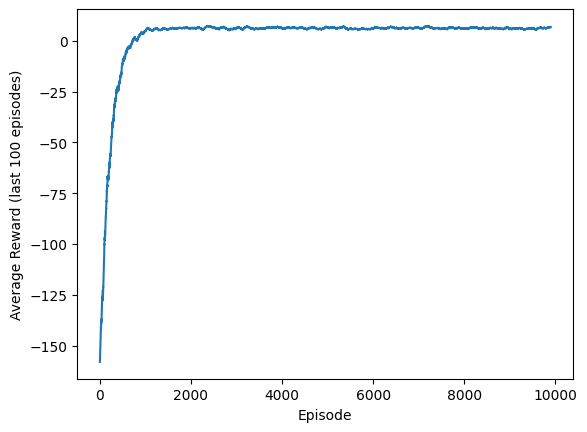

In [ ]:
rolling_avg_rewards = np.convolve(q_sum_of_rewards_per_episode, np.ones(100)/100, mode='valid')
plt.plot(rolling_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward (last 100 episodes)')
plt.show()

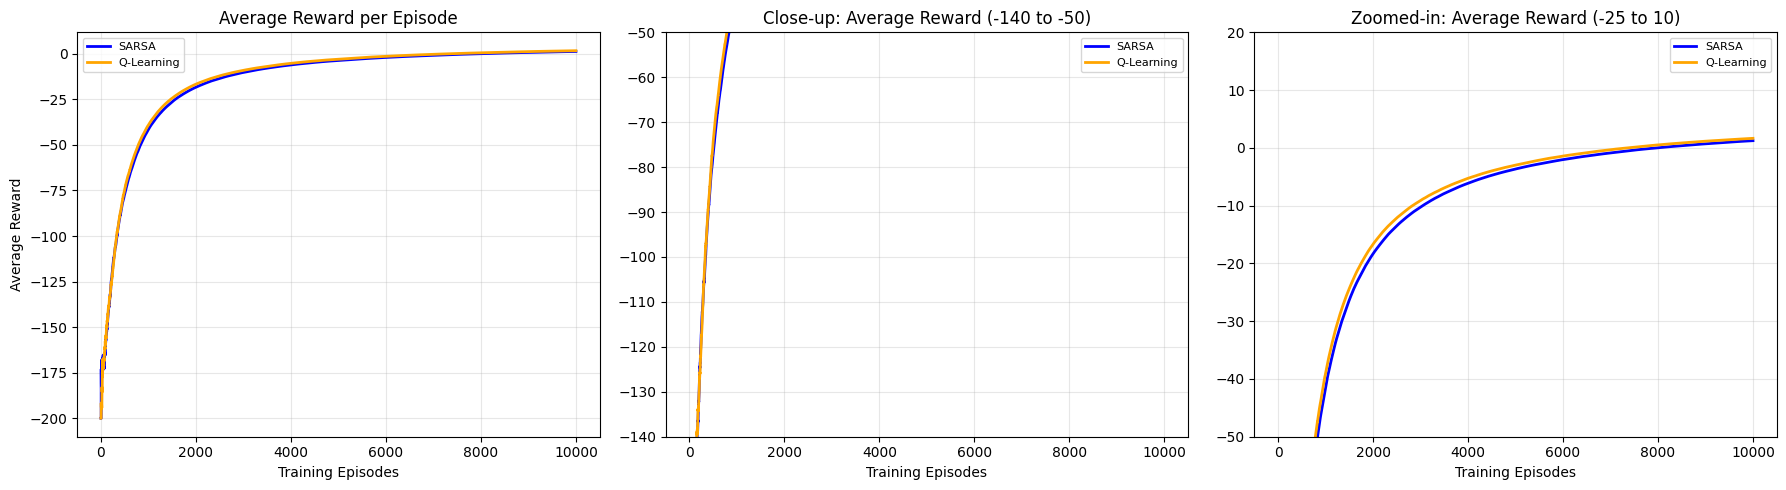

In [144]:
import numpy as np
import matplotlib.pyplot as plt

# Pre-allocate arrays of the correct size
n = len(sarsa_sum_of_rewards_per_episode)
episodes = np.arange(1, n + 1)

# Calculate cumulative averages in one step
sarsa_cumulative_avg = np.cumsum(sarsa_sum_of_rewards_per_episode) / episodes
q_learning_cumulative_avg = np.cumsum(q_sum_of_rewards_per_episode) / episodes


# Create x-axis values (number of episodes)
episodes = np.arange(1, len(sarsa_sum_of_rewards_per_episode) + 1)

# Create subplots in 2 rows x 3 columns (adding the new zoomed-in views)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# First Row: Average Reward Plots
# Original cumulative average rewards
axs[0].plot(episodes, sarsa_cumulative_avg, label='SARSA', linewidth=2, color='blue')
axs[0].plot(episodes, q_learning_cumulative_avg, label='Q-Learning', linewidth=2, color='orange')
axs[0].set_title('Average Reward per Episode', fontsize=12)
axs[0].set_ylabel('Average Reward', fontsize=10)
axs[0].set_xlabel('Training Episodes', fontsize=10)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=8)

# Close-up view (-500 to 0)
axs[1].plot(episodes, sarsa_cumulative_avg, label='SARSA', linewidth=2, color='blue')
axs[1].plot(episodes, q_learning_cumulative_avg, label='Q-Learning', linewidth=2, color='orange')
axs[1].set_title('Close-up: Average Reward (-140 to -50)', fontsize=12)
axs[1].set_ylim(-140, -50)
axs[1].set_xlabel('Training Episodes', fontsize=10)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=8)

# NEW: Zoomed-in view (-50 to 0)
axs[2].plot(episodes, sarsa_cumulative_avg, label='SARSA', linewidth=2, color='blue')
axs[2].plot(episodes, q_learning_cumulative_avg, label='Q-Learning', linewidth=2, color='orange')
axs[2].set_title('Zoomed-in: Average Reward (-25 to 10)', fontsize=12)
axs[2].set_ylim(-50, 20)
axs[2].set_xlabel('Training Episodes', fontsize=10)
axs[2].grid(True, alpha=0.3)
axs[2].legend(fontsize=8)

plt.tight_layout()
plt.show()

In [139]:
def select_action(state, Q, action_mask=None, epsilon=0.0):
    # If action_mask is not provided, consider all actions as valid
    valid_actions = np.where(action_mask == 1)[0] if action_mask is not None else np.arange(len(Q[state]))

    if np.random.rand() < epsilon:
        # Exploration: randomly choose among valid actions
        action_ = np.random.choice(valid_actions)
    else:
        # Exploitation: choose the best action among valid actions
        q_values_valid = Q[state][valid_actions]
        max_q = np.max(q_values_valid)
        
        # In case multiple actions have the same max Q-value, randomly choose among them
        best_actions = valid_actions[q_values_valid == max_q]
        action_ = np.random.choice(best_actions)

    return action_


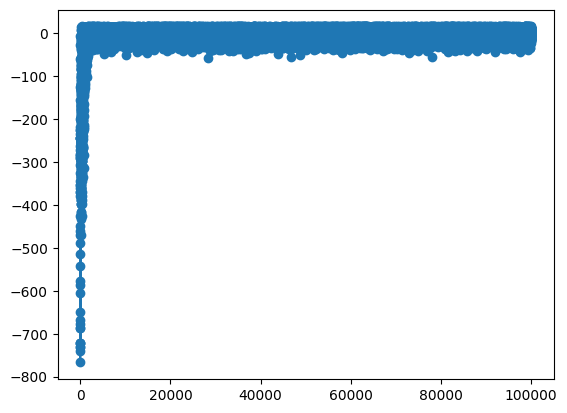

In [140]:
alpha = 0.1
gamma = 0.99
num_episodes = 100000
epsilon = 0.1

Q = np.zeros((env.observation_space.n, env.action_space.n))

sarsa_sum_of_rewards_per_episode = []

for episode in range(num_episodes):

    rewards = []

    # random state and i['action_mask] contains the actions that can be taken
    s, i = env.reset()

    a = select_action(s, Q, None, epsilon)

    while True:

        s_prime, r, is_done, is_terminated, i_prime = env.step(a)

        a_prime = select_action(s_prime, Q, None, epsilon)

        Q[s, a] += alpha * (r + gamma * Q[s_prime, a_prime] - Q[s, a])

        s = s_prime
        a = a_prime
        rewards.append(r)

        if is_done or is_terminated:
            break
    
    sarsa_sum_of_rewards_per_episode.append(np.sum(rewards))

# Plotting results
plt.plot(range(num_episodes), sarsa_sum_of_rewards_per_episode, 'o--')

probs_final = np.zeros_like(Q)
for state in range(env.observation_space.n):
    action_mask = np.ones(env.action_space.n, dtype=int)
    action_greedy = select_action(state, Q, action_mask, epsilon=0.0)
    probs_final[state, action_greedy] = 1.0

In [122]:
alpha = 0.5
gamma = 1
epsilon = 0.1
num_episodes = 100000

Q = np.zeros((env.observation_space.n, env.action_space.n))

q_sum_of_rewards_per_episode = []

for episode in range(num_episodes):

    if (episode + 1) % 10000 == 0:
        print(f"Episode {episode + 1}/{num_episodes}")

    rewards = []

    # random state and i['action_mask] contains the actions that can be taken
    s, i = env.reset()

    while True:


        a = select_action(s, Q, None, epsilon)

        s_prime, r, is_done, is_terminated, i_prime = env.step(a)
        rewards.append(r)

        max_q_value = np.max(Q[s_prime])
        max_actions = np.where(Q[s_prime] == max_q_value)[0]
        chosen_action = np.random.choice(max_actions)
        max_q = Q[s_prime][chosen_action]  # This will be the same as max_q_value


        Q[s, a] += alpha * (r + gamma * max_q - Q[s, a])

        if is_done or is_terminated:
            break

        s = s_prime
        i = i_prime
    
    q_sum_of_rewards_per_episode.append(np.sum(rewards))

# Plotting results
plt.plot(range(num_episodes), q_sum_of_rewards_per_episode, 'o--')

probs_final = np.zeros_like(Q)
for state in range(env.observation_space.n):
    action_mask = np.ones(env.action_space.n, dtype=int)
    action_greedy = select_action(state, Q, action_mask, epsilon=0.0)
    probs_final[state, action_greedy] = 1.0

Episode 10000/100000
Episode 20000/100000
Episode 30000/100000


KeyboardInterrupt: 

In [ ]:
rewards = []
for _ in range(10000):

    state, info = env.reset()
    env.render()
    total_reward = 0
    done = False

    while not done:
        action_mask = info.get('action_mask')
        action = select_action(state, Q, None, epsilon=0)  # Use greedy policy for evaluation
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward
    
    rewards.append(total_reward)